In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [3]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "CIFAR-10"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

In [4]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASS_NAMES)

In [5]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

### Load CIFAR-10 data

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Image scaling to 0-1
# train_images = train_images / 255.0
# test_images = test_images / 255.0

if train_labels.ndim == 2:
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()


total_data = f"Total Data on RAM -{(train_images.size + test_images.size) / 1024**2 : .2f} MB"
total_data

'Total Data on RAM - 175.78 MB'

### Displaying the first image in the training set

In [7]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

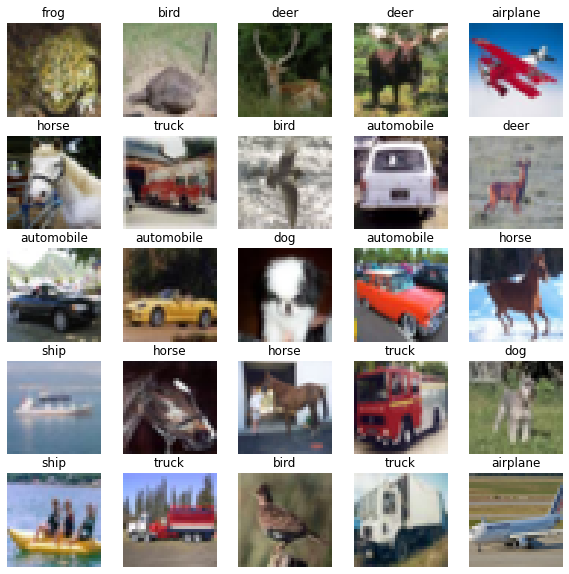

In [8]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, give_class_name(labels))

### Preprocessing the data

In [9]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [10]:
# train val split
from sklearn.model_selection import train_test_split

train_val_split = 0.2
train_set, val_set, y_train, y_val = train_test_split(train_images, y_train, test_size=train_val_split, random_state=42)

In [11]:
# data augmentation on train_set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    # height_shift_range=0.1,
    # width_shift_range=0.1,
    # zoom_range=0.05
)

train_set_aug = image_generator.flow(train_set, y_train, batch_size=64)

## MODELS

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


In [13]:
MODELS_PATH = ROOT_DIR / "models"
INPUT_SHAPE = train_images.shape[1:]
models_performance = {}
TRAIN_MODELS = True
# TRAIN_MODELS = False

In [14]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
        
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    if labels:
        cr = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
        
    plt.show()
    
def get_model_performance(y_true, y_pred):
    accuracy = accuracy_score(test_labels, test_labels_pred)
    f1_scr = f1_score(test_labels, test_labels_pred, average='weighted')
    precision_scr = precision_score(test_labels, test_labels_pred, average='weighted')
    recall_scr = recall_score(test_labels, test_labels_pred, average='weighted')
    
    performance = {
        "Accuracy": accuracy,
        "F1 Score": f1_scr,
        "Precision": precision_scr,
        "Recall": recall_scr
    }
    
    return performance

### Final Model (After Some Fine Tuning)

#### init

In [27]:
from tensorflow.keras.models import Sequential

model_name = "final_model"
weight_decay = 10e-5
# weight_decay = 0

def final_model(input_shape: int, num_classes: int, base_filters: int=32, dropout_rate: float=0.2,):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    #Convolutional layers
    #Conv Block 1 with l2 regularization
    model.add(Conv2D(base_filters, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Conv Block 2
    dropout_rate+=0.15
    model.add(Conv2D(base_filters*2, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*2, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Conv Block 3
    dropout_rate+=0.15
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(base_filters*4, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    model.add(Flatten())
    
    dropout_rate+=0.1
    model.add(Dense(128, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))

    # dropout_rate+=0.1
    # model.add(Dense(32, kernel_regularizer=l2(weight_decay)))
    # model.add(BatchNormalization())
    # model.add(Activation("relu"))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [28]:
model = final_model(INPUT_SHAPE, NUM_CLASSES, base_filters=64, dropout_rate=0.1)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                     

#### Train

In [29]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=20, mode='max')
# learning rate scheduler
def get_lr(epoch):
    lr_ = 1e-3
    k = 0.075
    lr = lr_ * np.exp(-k * epoch)
    return lr

lrd = LearningRateScheduler(lambda epoch: get_lr(epoch))# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check, lrd]

In [30]:
train_model = not (os.path.exists(f"{MODELS_PATH}/{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_set_aug, 
                        validation_data=(val_set, y_val),
                        epochs=75, batch_size=64,
                        callbacks=callbacks)

Epoch 1/75
624/625 [============================>.] - ETA: 0s - loss: 1.5918 - accuracy: 0.4877
Epoch 1: val_accuracy improved from -inf to 0.53070, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/final_model.h5
625/625 [==============================] - 9s 13ms/step - loss: 1.5915 - accuracy: 0.4878 - val_loss: 1.4668 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 2/75
624/625 [============================>.] - ETA: 0s - loss: 1.1134 - accuracy: 0.6652
Epoch 2: val_accuracy improved from 0.53070 to 0.69910, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/final_model.h5
625/625 [==============================] - 8s 13ms/step - loss: 1.1135 - accuracy: 0.6651 - val_loss: 1.0696 - val_accuracy: 0.6991 - lr: 9.2774e-04
Epoch 3/75
624/625 [============================>.] - ETA: 0s - loss: 0.9661 - accuracy: 0.7258
Epoch 3: val_accuracy did not improve from 0.69910
625/625 [==============================] - 8s 12ms/step - loss: 0.9661 - accuracy: 0.725

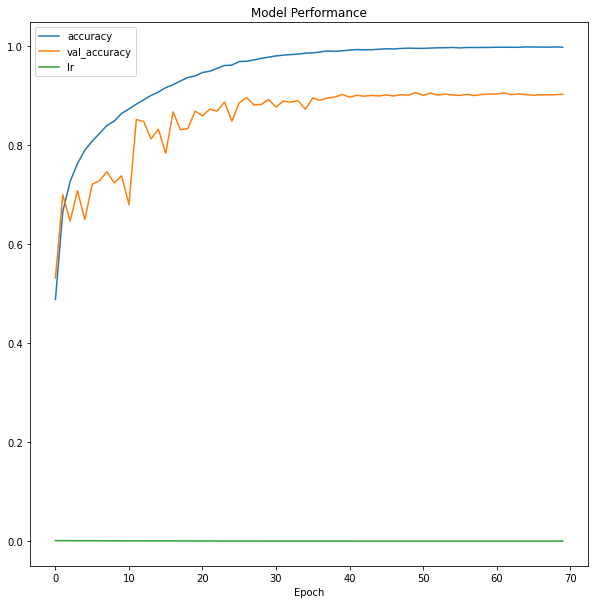

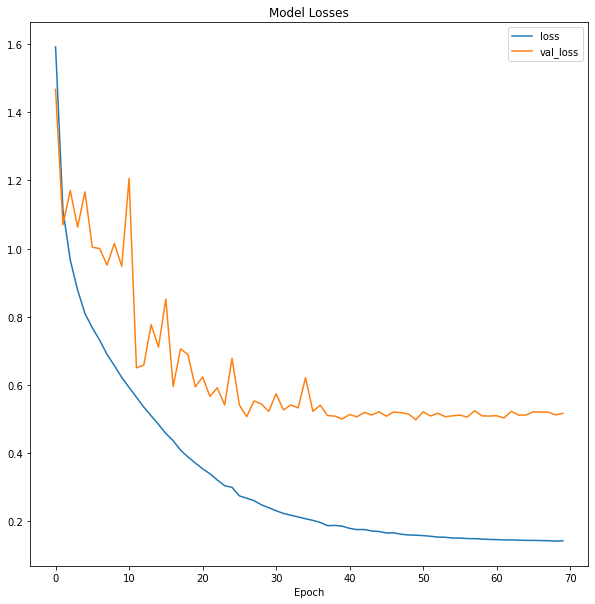

In [31]:
if train_model:
    plot_model_performance(history)

In [32]:
if train_model:
    model.evaluate(test_images, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5269 - accuracy: 0.8994


#### Testing and Evaluating

In [33]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

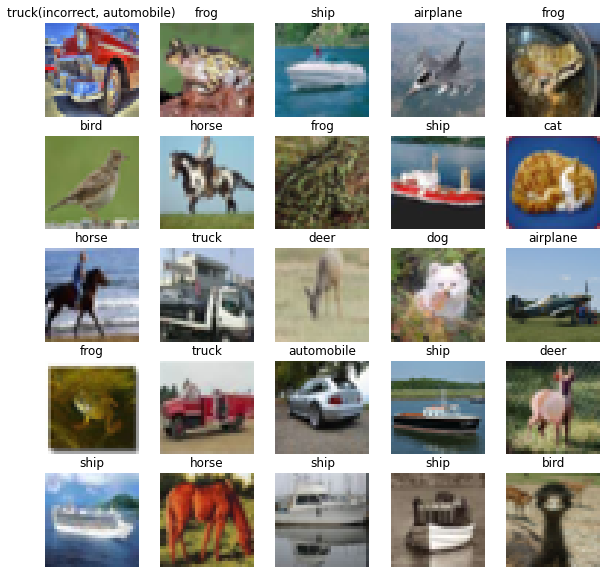

In [22]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


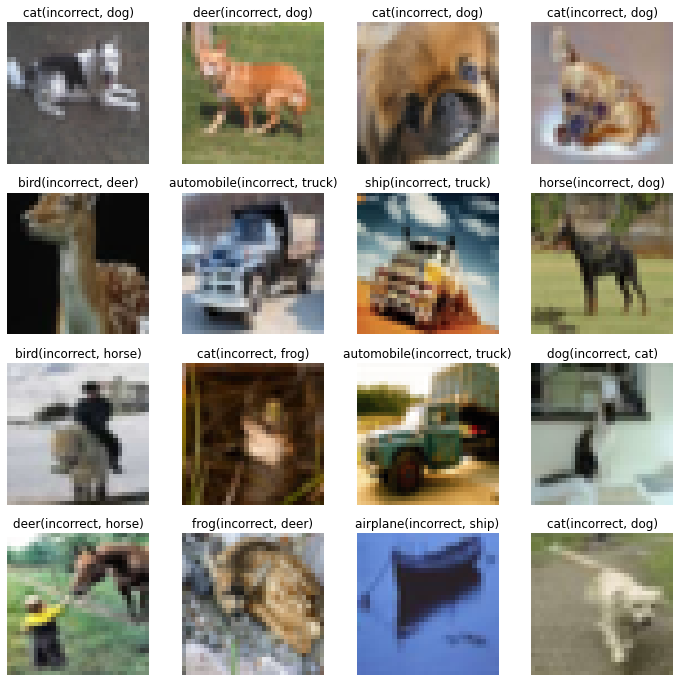

In [23]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.8983


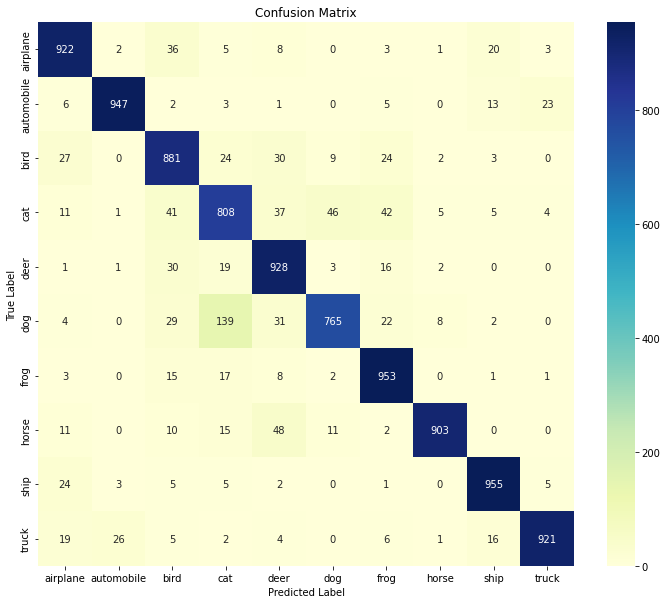

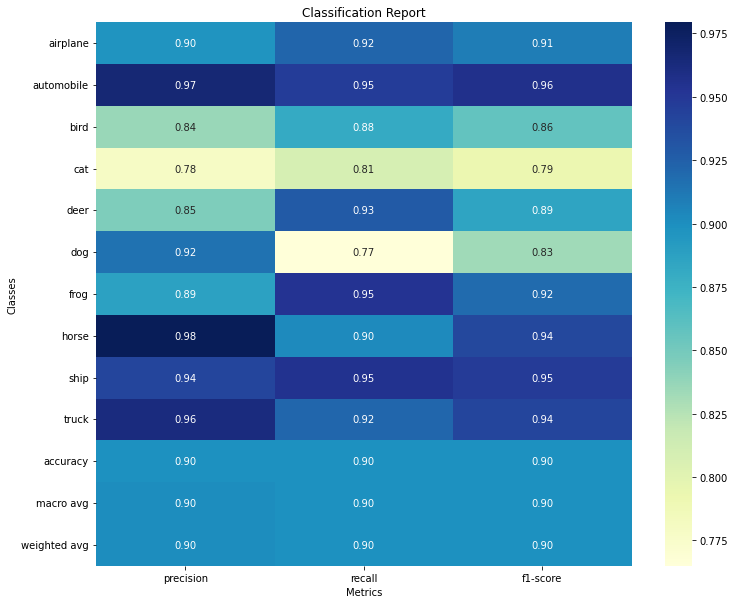

In [24]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance